In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import glob
import uuid
import random
import platform
import ecgdetectors
import torch
import torchvision
import utils
import utils.wavelet
import utils.data
import utils.data.augmentation
import utils.visualization
import utils.visualization.plot
import utils.torch
import utils.torch.nn
import utils.torch.nn as nn
import utils.torch.loss
import utils.torch.train
import utils.torch.data
import utils.torch.preprocessing
import utils.torch.models
import utils.torch.models.lego
import utils.torch.models.variational
import utils.torch.models.classification
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt
from scipy.stats import norm
from utils.signal import StandardHeader
from scipy.stats import lognorm, norm, halfnorm


# Define network

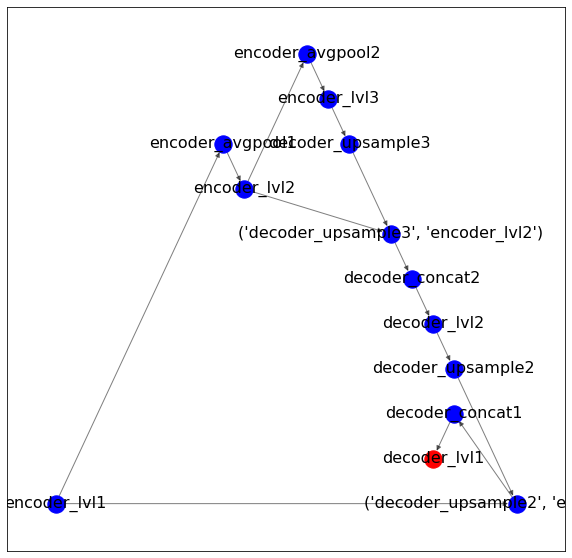

In [6]:
with open('./configurations/UNet3Levels.json', 'r') as f:
    execution = json.load(f)

model = nn.ModelGraph(execution['model']).float().eval()

# Plot model layout
plt.figure(figsize=(10,10))
model.draw_networkx()

In [4]:
%%timeit
tmp = model(torch.randn(1,1,2048).float())

12.8 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Performance comparisons [evaluation, workstation]
* [4Lvls,start16ch] 6.83 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
* [3Lvls,start32ch] 6.58 ms ± 476 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
* [3Lvls,start16ch] 4.51 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Performance comparisons [evaluation, laptop]
* [3Lvls,start16ch] 12.8 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [64]:
torch.allclose(out1,out2)

True

# Training the network

In [ ]:
torch.save()

In [ ]:
### IMPORT EXECUTION CONFIGURATION PARAMETERS (JSON) ###
with open("./parameters.json", 'r') as f:
    execution = json.load(f)

execution["root_directory"] = input_directory
execution["save_directory"] = output_directory

### SET RANDOM SEED ###
torch.manual_seed(execution['seed'])
random.seed(execution['seed'])
np.random.seed(execution['seed'])

### LOAD DATASET ###
# 0) Get classes
# print(list(glob.glob(os.path.join(input_directory,"*.mat"))))
classes = get_classes(input_directory,[os.path.split(f)[-1] for f in glob.glob(os.path.join(input_directory,"*.mat"))])

# 1) Load labels and compute detections
print("########## COMPUTING DETECTIONS ##########")
files = []
labels = []
detections = []
for f in tqdm.tqdm(glob.glob(os.path.join(input_directory,"*.mat"))):
    # Load data
    (signal,header) = wfdb.rdsamp(os.path.join(input_directory,os.path.splitext(f)[0]))
    signal = signal.astype('float32')

    # Use provided function for retrieving the true label
    fname, label_header, label = get_true_labels(f.replace('.mat','.hea'),classes)

    # Detect signal
    detector = ecgdetectors.Detectors(header['fs'])
    index_I = np.where(np.array(list(map(str.upper,header['sig_name']))) == 'I')[0][0]
    qrs = detector.pan_tompkins_detector(signal[:,index_I])

    # Store file name and label
    files.append(fname)
    detections.append(qrs)
    labels.append(label)

labels = np.array(labels)
files = np.array(files)

# 2) Train-test split
labels_train,labels_valid,files_train,files_valid,detections_train,detections_valid = sklearn.model_selection.train_test_split(
    labels,
    files,
    detections,
    stratify=labels.argmax(-1),
    random_state=execution['seed'],
)

# Save into folder
src.utils.pickledump(labels_train, './training/labels_train.pkl')
src.utils.pickledump(labels_valid, './training/labels_valid.pkl')
src.utils.pickledump(files_train, './training/files_train.pkl')
src.utils.pickledump(files_valid, './training/files_valid.pkl')
src.utils.pickledump(detections_train, './training/detections_train.pkl')
src.utils.pickledump(detections_valid, './training/detections_valid.pkl')

print("########## GENERATING TRAIN SET ##########")
# Generate train/test sets
X_train = []
y_train = []
X_valid = []
y_valid = []

for i in tqdm.tqdm(range(len(files_train))):
    # Retrieve the file information
    (signal,_) = wfdb.rdsamp(os.path.join(execution['root_directory'],files_train[i]))
    signal = signal.astype('float32').T

    if not execution['whole_record']:
        for j in range(1,len(detections_train[i])-1):
            onset = detections_train[i][j-1]
            offset = detections_train[i][j+1]
            interp = signal[:,onset:offset]
            interp = sp.interpolate.interp1d(np.linspace(0,1,interp.shape[1]),interp,axis=-1)(np.linspace(0,1,736)).astype('float32')
            X_train.append(interp)
            y_train.append(labels_train[i,:])
    else:
        X_train.append(signal)
        y_train.append(labels_train[i,:])

print("########## GENERATING TRAIN SET ##########")
for i in tqdm.tqdm(range(len(files_valid))):
    # Retrieve the file information
    (signal,_) = wfdb.rdsamp(os.path.join(execution['root_directory'],files_valid[i]))
    signal = signal.astype('float32').T

    if not execution['whole_record']:
        for j in range(1,len(detections_valid[i])-1):
            onset = detections_valid[i][j-1]
            offset = detections_valid[i][j+1]
            interp = signal[:,onset:offset]
            interp = sp.interpolate.interp1d(np.linspace(0,1,interp.shape[1]),interp,axis=-1)(np.linspace(0,1,736)).astype('float32')
            X_valid.append(interp)
            y_valid.append(labels_valid[i,:])
    else:
        X_valid.append(signal)
        y_valid.append(labels_valid[i,:])

y_valid = np.array(y_valid, dtype='float32')
y_train = np.array(y_train, dtype='float32')
try:
    X_train = np.array(X_train, dtype='float32')
    X_valid = np.array(X_valid, dtype='float32')
except:
    pass

### TRAIN MODEL ###
model = src.model.GAPModel(
    torch.nn.Sequential(
        src.model.CNN([12,16,16], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([16,16], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([16,32], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([32,32], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([32,64], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([64,128], regularization=execution['regularization_CNN']),
        torch.nn.MaxPool1d(3),
        src.model.CNN([128,256], regularization=execution['regularization_CNN'], regularize_extrema=False),
    ),
    src.model.DNN([256,128,64,32,9], regularization=execution['regularization_DNN'], regularize_extrema=False),
)

if execution['whole_record']:
    dataset_train = src.data.PaddedDataset(X_train, y_train, padding_length=execution['padding_length'],swapaxes=False, mode='edge')
    dataset_valid = src.data.PaddedDataset(X_valid, y_valid, padding_length=execution['padding_length'],swapaxes=False, mode='edge')
else:
    dataset_train = src.data.Dataset(X_train, y_train)
    dataset_valid = src.data.Dataset(X_valid, y_valid)

sampler_train = src.data.StratifiedSampler(y_train, *execution['sampler'])
sampler_valid = src.data.StratifiedSampler(y_valid, *execution['sampler'])

loader_train  = torch.utils.data.DataLoader(dataset_train, sampler=sampler_train, batch_size=execution['batch_size'], **execution['loader'])
loader_valid  = torch.utils.data.DataLoader(dataset_valid, sampler=sampler_valid, batch_size=execution['batch_size'], **execution['loader'])

# Loss
criterion = lambda X,y,y_pred: torch.nn.MultiLabelSoftMarginLoss(reduction='mean')(y_pred, y.long())
metric = lambda X,y,y_pred: src.evaluate.compute_beta_score(y.long().cpu().detach().numpy(),(torch.nn.functional.softmax(y_pred,-1) > 0.5).cpu().detach().numpy())[-1]

state = {
    'epoch'         : 0,
    'device'        : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'optimizer'     : src.utils.class_selector('torch.optim',execution['optimizer']['name'])(model.parameters(), **execution['optimizer']['arguments']),
    'root_dir'      : './'
}
if 'scheduler' in execution:
    state['scheduler'] = src.utils.class_selector('torch.optim.lr_scheduler',execution['scheduler']['name'])(state['optimizer'], **execution['scheduler']['arguments'])

print("########## TRAINING THE MODEL ##########")
state = src.train.train_model(model,state,execution,loader_train, loader_valid, criterion, metric, smaller=False)
